In [1]:
# import all necessary libraries

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

!pip install folium 
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.5 MB/s  eta 0:00:01
Libraries imported.


In [2]:
#import train station coordinates .csv file 
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_bf77b264c8f04eac99364851c44fb49e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ofF-7eamFO2xJTqWpOARZIm5SqpeYwDWOHANgJdOVBA3',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_bf77b264c8f04eac99364851c44fb49e.get_object(Bucket='capstoneproject-donotdelete-pr-bk4b5a8reooeoh',Key='mrt_lrt_data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

trains = pd.read_csv(body)
print(trains.shape)
trains.head()

(157, 4)


,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [3]:
# drop the 'type' column as it is not needed and rename the column titles.
trains.drop(['type'], axis = 'columns', inplace = True)
trains.columns = ['Station Name','Latitude', 'Longitude']
trains.head()

,Station Name,Latitude,Longitude
0,Jurong East,1.333207,103.742308
1,Bukit Batok,1.349069,103.749596
2,Bukit Gombak,1.359043,103.751863
3,Choa Chu Kang,1.385417,103.744316
4,Yew Tee,1.397383,103.747523


In [4]:
# Get coordinates for Singapore to plot map

address = 'Singapore'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.3408630000000001, 103.83039182212079.


In [5]:
# create map of Singapore 
map_SGP = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers for train stations to map
for lat, lng, station_name in zip(trains['Latitude'], trains['Longitude'], trains['Station Name']):
    label = '{}'.format(station_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SGP)  
    
map_SGP

In [6]:
CLIENT_ID = 'FNQDUJW5MGLA44OPZORKQQTDUXKX34LZJUNNKIKPKUU542SK' # your Foursquare ID
CLIENT_SECRET = '45MD0PZMYQOIBTYMQ5JJO4GGEIOIFXNTPXIAUSXOQS1EIIFB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FNQDUJW5MGLA44OPZORKQQTDUXKX34LZJUNNKIKPKUU542SK
CLIENT_SECRET:45MD0PZMYQOIBTYMQ5JJO4GGEIOIFXNTPXIAUSXOQS1EIIFB


In [57]:
# function to get venues nearby (within 500m)
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station Name', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

In [58]:
trains_venues = getNearbyVenues(names=trains['Station Name'],
                                   latitudes=trains['Latitude'],
                                   longitudes=trains['Longitude']
                                  )

Jurong East
Bukit Batok
Bukit Gombak
Choa Chu Kang
Yew Tee
Kranji
Marsiling
Woodlands
Admiralty
Sembawang
Yishun
Khatib
Yio Chu Kang
Ang Mo Kio
Bishan
Braddell
Toa Payoh
Novena
Newton
Orchard
Somerset
Dhoby Ghaut
City Hall
Raffles Place
Marina Bay
Marina South Pier
Tuas Link
Tuas West Road
Tuas Crescent
Gul Circle
Joo Koon
Pioneer
Boon Lay
Lakeside
Chinese Garden
Clementi
Dover
Buona Vista
Commonwealth
Queenstown
Redhill
Tiong Bahru
Outram Park
Tanjong Pagar
Bugis
Lavender
Kallang
Aljunied
Paya Lebar
Eunos
Kembangan
Bedok
Tanah Merah
Simei
Tampines
Pasir Ris
Expo
Changi Airport
HarbourFront
Chinatown
Clarke Quay
Little India
Farrer Park
Boon Keng
Potong Pasir
Woodleigh
Serangoon
Kovan
Hougang
Buangkok
Sengkang
Punggol
Bras Basah
Esplanade
Promenade
Nicoll Highway
Stadium
Mountbatten
Dakota
MacPherson
Tai Seng
Bartley
Lorong Chuan
Marymount
Caldecott
Botanic Gardens
Farrer Road
Holland Village
one-north
Kent Ridge
Haw Par Villa
Pasir Panjang
Labrador Park
Telok Blangah
Bayfront
Bukit Pa

In [59]:
print(trains_venues.shape)
trains_venues.head()

(5396, 7)


,Station Name,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jurong East,1.333207,103.742308,UNIQLO,1.333175,103.743160,Clothing Store
1,Jurong East,1.333207,103.742308,MUJI 無印良品,1.333187,103.743064,Furniture / Home Store
2,Jurong East,1.333207,103.742308,The Rink,1.333424,103.740345,Skating Rink
3,Jurong East,1.333207,103.742308,Johan Paris,1.334083,103.742384,Bakery
4,Jurong East,1.333207,103.742308,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant


In [60]:
# of venues returned for each train station
trains_venues.groupby('Station Name').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station Name,,,,,,
Admiralty,58,58,58,58,58,58
Aljunied,51,51,51,51,51,51
Ang Mo Kio,40,40,40,40,40,40
Bakau,11,11,11,11,11,11
Bangkit,13,13,13,13,13,13
...,...,...,...,...,...,...
Woodleigh,10,10,10,10,10,10
Yew Tee,11,11,11,11,11,11
Yio Chu Kang,21,21,21,21,21,21


In [61]:
print('There are {} uniques categories.'.format(len(trains_venues['Venue Category'].unique())))

There are 336 uniques categories.


**Analyse each train station

In [62]:
# one hot encoding
trains_onehot = pd.get_dummies(trains_venues[['Venue Category']], prefix="", prefix_sep="")

# add station name column back to dataframe
trains_onehot['Station Name'] = trains_venues['Station Name'] 

# move station name column to the first column
fixed_columns = [trains_onehot.columns[-1]] + list(trains_onehot.columns[:-1])
trains_onehot = trains_onehot[fixed_columns]

trains_onehot.head()

,Station Name,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
trains_onehot.shape

(5396, 337)

In [64]:
# Group rows by station name and by taking the mean of the frequency of occurrence of each category
trains_grouped = trains_onehot.groupby('Station Name').mean().reset_index()
trains_grouped

,Station Name,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Admiralty,0.0,0.0,0.0,0.0,0.017241,0.017241,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aljunied,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ang Mo Kio,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bakau,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bangkit,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Woodleigh,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,Yew Tee,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,Yio Chu Kang,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,Yishun,0.0,0.0,0.0,0.0,0.000000,0.038462,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Define each station with the top 5 most common venues. Printing is optional
num_top_venues = 5

for station in trains_grouped['Station Name']:
    #print("----"+station+"----")
    temp = trains_grouped[trains_grouped['Station Name'] == station].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [76]:
#Convert into dataframe with top 5 venues per train station
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
trains_venues_sorted = pd.DataFrame(columns=columns)
trains_venues_sorted['Station Name'] = trains_grouped['Station Name']

for ind in np.arange(trains_grouped.shape[0]):
    trains_venues_sorted.iloc[ind, 1:] = return_most_common_venues(trains_grouped.iloc[ind, :], num_top_venues)

trains_venues_sorted.head()

,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Admiralty,Japanese Restaurant,Shopping Mall,Café,Indian Restaurant,Electronics Store
1,Aljunied,Chinese Restaurant,Coffee Shop,Noodle House,Asian Restaurant,Vegetarian / Vegan Restaurant
2,Ang Mo Kio,Coffee Shop,Dessert Shop,Food Court,Bubble Tea Shop,Supermarket
3,Bakau,Bus Station,Shopping Mall,Indonesian Restaurant,Fast Food Restaurant,Breakfast Spot
4,Bangkit,Food Court,Convenience Store,Noodle House,Fast Food Restaurant,Trail


**Cluster train stations

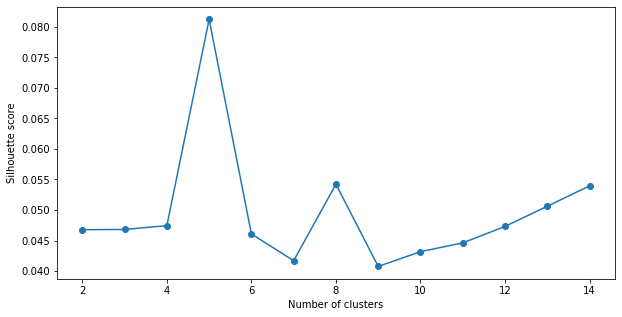

In [78]:
# find optimal k

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
indices = []
score = []
trains_grouped_clustering = trains_grouped.drop('Station Name', 1)

for kclusters in range (2,15):
    
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit_predict(trains_grouped_clustering)

    silh = silhouette_score(trains_grouped_clustering, kmeans)

    indices.append(kclusters)
    score.append(silh)
    
plot(indices, score, "Number of clusters", "Silhouette score")


Create new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [79]:
kmeans = KMeans(n_clusters= 5, random_state=0).fit(trains_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
trains_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

trains_merged = trains

# merge trains_grouped with trains to add latitude/longitude for each neighborhood
trains_merged = trains_merged.join(trains_venues_sorted.set_index('Station Name'), on='Station Name')

trains_merged.head() 

,Station Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Jurong East,1.333207,103.742308,3,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Café,Shopping Mall
1,Bukit Batok,1.349069,103.749596,1,Coffee Shop,Fast Food Restaurant,Food Court,Malay Restaurant,Chinese Restaurant
2,Bukit Gombak,1.359043,103.751863,3,Food Court,Vegetarian / Vegan Restaurant,Stadium,Coffee Shop,Chinese Restaurant
3,Choa Chu Kang,1.385417,103.744316,1,Café,Fast Food Restaurant,Coffee Shop,Portuguese Restaurant,Bakery
4,Yew Tee,1.397383,103.747523,1,Fast Food Restaurant,Cosmetics Shop,Pool,Café,Sandwich Place


In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**3 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 5, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(trains_merged['Latitude'], trains_merged['Longitude'], trains_merged['Station Name'], trains_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

**EXAMINE CLUSTERS

In [81]:
print('Cluster 1 (red):')
trains_merged.loc[trains_merged['Cluster Labels'] == 0, trains_merged.columns[[0] + list(range(4, trains_merged.shape[1]))]]

Cluster 1 (red):


,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
152,Punggol Point,Light Rail Station,Campground,Yunnan Restaurant,Fishing Spot,Farmers Market


In [82]:
print('Cluster 2 (dark blue):')
trains_merged.loc[trains_merged['Cluster Labels'] == 1, trains_merged.columns[[0] + list(range(4, trains_merged.shape[1]))]]

Cluster 2 (dark blue):


,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Bukit Batok,Coffee Shop,Fast Food Restaurant,Food Court,Malay Restaurant,Chinese Restaurant
3,Choa Chu Kang,Café,Fast Food Restaurant,Coffee Shop,Portuguese Restaurant,Bakery
4,Yew Tee,Fast Food Restaurant,Cosmetics Shop,Pool,Café,Sandwich Place
5,Kranji,Racetrack,Night Market,Noodle House,Jazz Club,Bus Line
6,Marsiling,Food Court,Bus Stop,Grocery Store,Market,Flower Shop
...,...,...,...,...,...,...
145,Coral Edge,Park,Bus Stop,Soccer Field,Café,College Cafeteria
146,Riviera,Gastropub,Fast Food Restaurant,Fishing Spot,Golf Course,Bus Stop
147,Kadaloor,Golf Course,Music Venue,Fishing Spot,Park,Fast Food Restaurant
148,Oasis,Fast Food Restaurant,Supermarket,Café,Coffee Shop,Bridge


In [83]:
print('Cluster 3 (light blue):')
trains_merged.loc[trains_merged['Cluster Labels'] == 2, trains_merged.columns[[0] + list(range(4, trains_merged.shape[1]))]]

Cluster 3 (light blue):


,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Gul Circle,Coffee Shop,Park,Electronics Store,Exhibit,Farmers Market
137,Kupang,Coffee Shop,Bridge,Park,Pizza Place,Farm


In [84]:
print('Cluster 4 (orange):')
trains_merged.loc[trains_merged['Cluster Labels'] == 3, trains_merged.columns[[0] + list(range(4, trains_merged.shape[1]))]]

Cluster 4 (orange):


,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Jurong East,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Café,Shopping Mall
2,Bukit Gombak,Food Court,Vegetarian / Vegan Restaurant,Stadium,Coffee Shop,Chinese Restaurant
7,Woodlands,Japanese Restaurant,Shopping Mall,Café,Indian Restaurant,Electronics Store
8,Admiralty,Japanese Restaurant,Shopping Mall,Café,Indian Restaurant,Electronics Store
10,Yishun,Food Court,Chinese Restaurant,Coffee Shop,Pharmacy,Arcade
...,...,...,...,...,...,...
151,Teck Lee,Light Rail Station,Thai Restaurant,Café,Bridge,Music Venue
153,Samudera,Soccer Field,Bar,Beer Garden,Beer Bar,Light Rail Station
154,Nibong,Light Rail Station,Soccer Field,Bar,Beer Garden,BBQ Joint
155,Sumang,Japanese Restaurant,Coffee Shop,Food Court,Chinese Restaurant,Fast Food Restaurant


In [85]:
print('Cluster 5 (red):')
trains_merged.loc[trains_merged['Cluster Labels'] == 4, trains_merged.columns[[0] + list(range(4, trains_merged.shape[1]))]]

Cluster 5 (red):


,Station Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,Tuas West Road,Malay Restaurant,Yunnan Restaurant,Fishing Spot,Farm,Farmers Market
